In [94]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from pytesseract import*

from fuzzywuzzy import fuzz

from sklearn.utils import shuffle

from util import randomChoice, lineToTensor, readFile

import re

# other libraries required by this notebook
import string
import time
import math
import random
import glob
import os

# the number of hidden neurons of the RNN
n_hidden = 128*3

# a list containing all ascii caracters and some german exclusive ones
all_letters = string.ascii_letters + " .,;'" + "äÄüÜöÖß"
n_letters = len(all_letters)

(4032, 3024, 3)


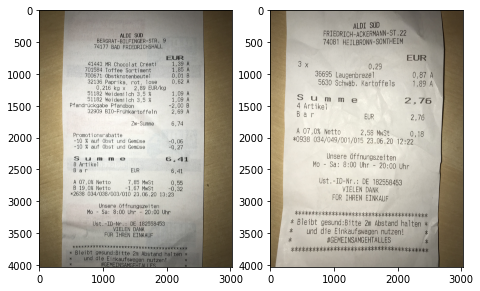

In [95]:
imageNames = ["23_06_2020.jpg", "IMG_0944.jpg"]
images = []
figNo = 1
fig=plt.figure(figsize=(20, 6))
for imageName in imageNames:
    img0 = cv2.imread("data/images/aldi/" + imageName)
    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    images.append(img0)
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(img0)
    figNo +=1
    
print(img0.shape)
plt.show()

In [140]:
# y0, x0, y1, x1
bbox_0 = np.array([[800, 1000, 900, 1860],[900, 1000, 990, 1800],[990, 1000, 1080, 1750],[1080, 1000, 1180, 1880],[1260, 1000, 1360, 1800],[1360, 1000, 1460, 1800],[1540, 1000, 1650, 1870]]) 
bbox_1 = np.array([[960,1009,1080,1650],[1080,1009,1220,1980]])
bboxes = np.array((bbox_0,bbox_1))
bboxes

<ipython-input-140-c5daa4e2dbbe>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  bboxes = np.array((bbox_0,bbox_1))


array([array([[ 800, 1000,  900, 1860],
       [ 900, 1000,  990, 1800],
       [ 990, 1000, 1080, 1750],
       [1080, 1000, 1180, 1880],
       [1260, 1000, 1360, 1800],
       [1360, 1000, 1460, 1800],
       [1540, 1000, 1650, 1870]]),
       array([[ 960, 1009, 1080, 1650],
       [1080, 1009, 1220, 1980]])], dtype=object)

In [141]:
imagesResized = []
for image in images:
    imagesResized.append(cv2.resize(image, dsize=(800,800), interpolation=cv2.INTER_CUBIC))

In [142]:
# resize the bounding boxes
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
bboxesResized = np.copy(bboxes)
for i, bbox in enumerate(bboxes):
    for j, box in enumerate(bbox):
        print(box)
        box = [int(a * b) for a, b in zip(box, ratioLst)] 
        bboxesResized[i][j] = box

[ 800 1000  900 1860]
[ 900 1000  990 1800]
[ 990 1000 1080 1750]
[1080 1000 1180 1880]
[1260 1000 1360 1800]
[1360 1000 1460 1800]
[1540 1000 1650 1870]
[ 960 1009 1080 1650]
[1080 1009 1220 1980]


In [143]:
bboxesResized

array([array([[158, 264, 178, 492],
       [178, 264, 196, 476],
       [196, 264, 214, 462],
       [214, 264, 234, 497],
       [250, 264, 269, 476],
       [269, 264, 289, 476],
       [305, 264, 327, 494]]),
       array([[190, 266, 214, 436],
       [214, 266, 242, 523]])], dtype=object)

(4032, 3024, 3)


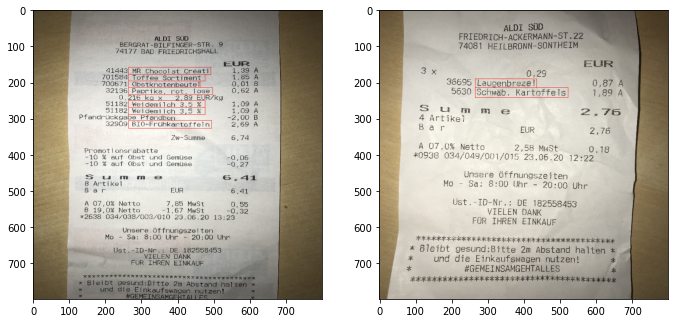

In [144]:
figNo = 1
fig=plt.figure(figsize=(30, 10))
for i, image in enumerate(imagesResized):
    img_clone = np.copy(image)
    bbox_clone = bboxesResized[i].astype(int)
    for i in range(len(bboxesResized[i])):
        cv2.rectangle(img_clone, (bbox_clone[i][1], bbox_clone[i][0]), (bbox_clone[i][3], bbox_clone[i][2]), color=(255,0,0), thickness=1)
        
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(img_clone)
    figNo +=1
    
print(img0.shape)
plt.show()

In [145]:
# the Keyword Context Network
class KCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(KCN, self).__init__()
    
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [146]:
# the ocr component build using tesseract
class OCR(object):
    def __init__(self, language):
        super(OCR, self).__init__()
        
        self.language = language
    
    def getString(self, image, boundingBox=[]):
        if not len(boundingBox):
            return pytesseract.image_to_string(image,lang=self.language)
        y0, x0, y1, x1 = np.array(boundingBox)
        h = y1-y0
        w = x1-x0
        res = image[y0:y0+h,x0:x0+w]
        return pytesseract.image_to_string(res,lang=self.language)
    
    def getDict(self, image):
        return pytesseract.image_to_data(image, output_type=Output.DICT) 
    
    def getTrainingData(self, image, bbox):
        ocrWhole = self.getString(image)
        regex1 = re.compile('[^a-zA-ZäÄüÜöÖ\n]')
        ocrWhole = regex1.sub('', ocrWhole).upper()
        ocrWhole = ocrWhole.split("\n")
        
        ocrBbox = []
        regex2 = re.compile('[^a-zA-ZäÄüÜöÖ]')
        for i in range(len(bbox)):
            s = self.getString(image, bbox[i].astype(int))
            res = regex2.sub('', s).upper()
            ocrBbox.append(res)
            
        for word1 in ocrBbox:
            for word2 in ocrWhole:
                distance = fuzz.ratio(word1, word2)
                if distance > 60 and word1 and word2:
                    ocrWhole.remove(word2)
                    
        while("" in ocrWhole) : 
            ocrWhole.remove("") 
    
        while("" in ocrBbox) : 
            ocrBbox.remove("") 
            
        return ocrWhole, ocrBbox

In [147]:
ocr = OCR("deu")

In [148]:
training_data = []
for i in range(len(imagesResized)):
    ocrWhole, ocrBbox = ocr.getTrainingData(imagesResized[i], bboxesResized[i])
    training_data.append([ocrBbox, ocrWhole])

In [149]:
kcn = KCN(n_letters, n_hidden, 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(kcn.parameters(), 0.001)

In [150]:
x = [[],[]]
categories = [0,1]
for data in training_data:
    for line in data[0]:
        x[0].append(line)
    for line in data[1]:
        x[1].append(line)
for product in readFile("../webapp/allproducts.txt"):
    x[0].append(product)

In [151]:
# returns the prediction of the network by passing every letterTensor through the network
def evaluate(line_tensor):
    hidden = kcn.initHidden() # initialize a hidden tensor for the first feed
    
    # pass every letter tensor through the network
    for i in range(line_tensor.size()[0]):
        output, hidden = kcn(line_tensor[i], hidden)

    return output

In [152]:
# returns a random training example
def randomTrainingExample():
    category = randomChoice(categories)
    line = randomChoice(x[category])
    category_tensor = torch.tensor([category], dtype=torch.long)

    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [153]:
# retieves the category of an output by the network
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return categories[category_i], category_i

In [154]:
# performs a training step with the given line and category tensor
def train(category_tensor, line_tensor):
    
    hidden = kcn.initHidden() # initialize a hidden tensor for the first feed

    optimizer.zero_grad() # reset the current gradients 
    
    # pass every letter tensor through the network
    for i in range(line_tensor.size()[0]):
        output, hidden = kcn(line_tensor[i], hidden)
    
    # define our loss criterion
    loss = criterion(output, category_tensor)
    loss.backward()

   
    # Add parameters gradients to their values, multiplied by learning rate (Gradient Descent)
    optimizer.step()

    return output, loss.item()

5000 16% (0m 9s) 0.5418 DUSCH / 0 ✓
10000 33% (0m 18s) 0.4661 EUR / 1 ✓
15000 50% (0m 27s) 0.1011 ORANGENSAFT / 0 ✓
20000 66% (0m 37s) 0.0000 STACHELBEERE / 0 ✓
25000 83% (0m 48s) 0.0000 KEARLKKKERKEKKTKEKKRKERRKER / 1 ✓
30000 100% (0m 58s) 0.0833 SUMME / 1 ✓


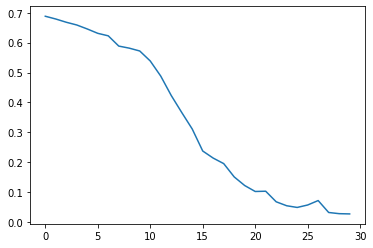

In [155]:
n_iters = 30000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

# plot the graph of the losses returned during training
plt.figure()
plt.plot(all_losses)

In [156]:
kcn.eval()

KCN(
  (i2h): Linear(in_features=448, out_features=384, bias=True)
  (i2o): Linear(in_features=448, out_features=2, bias=True)
)

In [157]:
def predict(input_line, n_predictions=2):
        print('\n> %s' % input_line)
        with torch.no_grad():
            output = evaluate(lineToTensor(input_line))

            # Get top N categories
            topv, topi = F.softmax(output, dim=1).topk(n_predictions, 1, True)
            predictions = []

            for i in range(n_predictions):
                value = topv[0][i].item()
                category_index = topi[0][i].item()
                print('(%.2f) %s' % (value, categories[category_index]))
                predictions.append([value, categories[category_index]])

In [158]:
for item in x[0]:
    predict(item.upper())


> MRCHOCOLATCREATI
(1.00) 0
(0.00) 1

> TOFFEESORTIMENT
(1.00) 0
(0.00) 1

> OBSTKMOTENBEUTEL
(1.00) 0
(0.00) 1

> WEIDEMILCH
(1.00) 0
(0.00) 1

> WEIDEMILCH
(1.00) 0
(0.00) 1

> BIOIHKARTOFFELN
(0.99) 0
(0.01) 1

> LAUSENBREZEL
(1.00) 0
(0.00) 1

> SCHWÄBKARTOFFELS
(1.00) 0
(0.00) 1

> BAUERNSCHMAUS
(1.00) 0
(0.00) 1

> BUTTER
(0.99) 0
(0.01) 1

> ERDNUSSBUTTER
(0.99) 0
(0.01) 1

> GUACAMOLE
(1.00) 0
(0.00) 1

> HONIG
(1.00) 0
(0.00) 1

> HUMMUS
(1.00) 0
(0.00) 1

> LEBERWURST
(1.00) 0
(0.00) 1

> MARMELADE
(0.99) 0
(0.01) 1

> MARGARINE
(1.00) 0
(0.00) 1

> NOUGATCREME
(0.98) 0
(0.02) 1

> NUTELLA
(1.00) 0
(0.00) 1

> SCHMALZ
(1.00) 0
(0.00) 1

> SIRUP
(0.64) 0
(0.36) 1

> STREICHKÄSE
(1.00) 0
(0.00) 1

> STREICHWURST
(1.00) 0
(0.00) 1

> ZUCKERRÜBENSIRUP
(1.00) 0
(0.00) 1

> BAGUETTE
(1.00) 0
(0.00) 1

> CIABATTA
(1.00) 0
(0.00) 1

> FLADENBROT
(1.00) 0
(0.00) 1

> GLUTENFREIES BROT
(1.00) 0
(0.00) 1

> HOLZOFENBROT
(1.00) 0
(0.00) 1

> KNÄCKEBROT
(1.00) 0
(0.00) 1

> ROGGENBROT
(0

In [159]:
for item in x[1]:
    predict(item.upper())


> ALDTSÜD
(0.95) 1
(0.05) 0

> BERGRATBILFINGERSTR
(1.00) 1
(0.00) 0

> BADFRIEDRICHSHALL
(1.00) 1
(0.00) 0

> PAPRIKAROTLOSE
(0.99) 1
(0.01) 0

> KGXEURKG
(0.92) 1
(0.08) 0

> PFANDRÜCKGABEPFANDBOR
(1.00) 1
(0.00) 0

> PURRPOP
(0.96) 1
(0.04) 0

> ZWSUMME
(0.96) 1
(0.04) 0

> PROMOTIONSRABATTE
(1.00) 1
(0.00) 0

> AUFOBSTUNDGEMÜSE
(1.00) 1
(0.00) 0

> AUFOBSTUNDGEMÜSE
(1.00) 1
(0.00) 0

> SUMME
(0.92) 1
(0.08) 0

> ARTIKEL
(0.94) 1
(0.06) 0

> BRAEUR
(0.89) 1
(0.11) 0

> ANETTOMWST
(1.00) 1
(0.00) 0

> BNETTOMWST
(0.98) 1
(0.02) 0

> UNSEREÖFFNUNGSZEITEN
(1.00) 1
(0.00) 0

> MOSAUHRUHR
(0.99) 1
(0.01) 0

> BERIDNRDE
(0.95) 1
(0.05) 0

> VIELENDANK
(0.99) 1
(0.01) 0

> FÜRIHRENEINKAUF
(1.00) 1
(0.00) 0

> ALDISUNSI
(0.98) 1
(0.02) 0

> FRIEDRICHACKERMANNST
(1.00) 1
(0.00) 0

> HEILBRONNSONTHEIM
(1.00) 1
(0.00) 0

> SEX
(0.86) 1
(0.14) 0

> MM
(0.84) 1
(0.16) 0

> EUR
(0.96) 1
(0.04) 0

> NETTOMUST
(0.99) 1
(0.01) 0

> UNSEREÖFFNUNGSZEITEN
(1.00) 1
(0.00) 0

> MOSAUHRUHR
(0.99) 1
(0.01

In [136]:
predict("VanilleEis".upper())


> VANILLE EIS
(0.55) 0
(0.45) 1
